In [1]:
import pandas as pd
import pysam
import glob
import pathlib
import xarray as xr
from ALLCools.count_matrix.dataset import _CountQuantifier
import time
import subprocess
import numpy as np
from tqdm import tqdm
import os
from ALLCools.mcds import MCDS
import seaborn as sns
from matplotlib import pyplot as plt

## gen male and female dmr zarr

In [2]:
import ray
ray.init(ignore_reinit_error=True, _temp_dir='/tmp/ray_rachel')

2024-01-16 14:41:36,843	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.7.12', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '10.7.30.230', 'raylet_ip_address': '10.7.30.230', 'redis_address': None, 'object_store_address': '/tmp/ray_rachel/session_2024-01-16_14-41-34_498278_413848/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray_rachel/session_2024-01-16_14-41-34_498278_413848/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray_rachel/session_2024-01-16_14-41-34_498278_413848', 'metrics_export_port': 50729, 'gcs_address': '10.7.30.230:65201', 'address': '10.7.30.230:65201', 'node_id': 'e0c4cb6573de72776d13c20b8a236c2c9beff77c479a6a9c3c74ddd6'})

In [3]:
@ray.remote(num_cpus=1)
def _count_single_region_set_for_single_allc(sample, allc_path, mc_types, region_path, obs_dim, region_dim):
    """Get cell-by-region-by-mc_types count matrix, save to zarr."""
    total_mc_types = list(set(mc_types))

    with pysam.TabixFile(allc_path) as allc:
        region_ids = []
        sample_data = []
        region_chunks = pd.read_csv(region_path, index_col=3, sep='\t', chunksize=2000)
        for chunk in region_chunks:
            region_ids += chunk.index.tolist()
            for _, (chrom, start, end, _,_,_) in chunk.iterrows():
                count_quant = _CountQuantifier(mc_types=total_mc_types)
                try:
                    allc_lines = allc.fetch(chrom, start, end)
                    for line in allc_lines:
                        count_quant.read_line(line)
                except ValueError:
                    # got value error, this chrom not exist in allc
                    pass
                sample_data.append(count_quant.summary())
        data = xr.DataArray(
            np.array([sample_data]),
            coords=[[sample], region_ids, total_mc_types, ["mc", "cov"]],
            dims=[obs_dim, region_dim, "mc_type", "count_type"],
        )
        return data

In [4]:
mc_types = ['CGN']
allc_paths_dir = '/ceph/gale-1/qzeng/AmbData/CellType_Allc'
kind = '2-BothGender.CellType.Age'
obs_dim='sample'
region_dim='dmr_region'

In [5]:
ready_celltypes = [pathlib.Path(path).name.split('.')[0] for path in glob.glob(f'{kind}/DMR/*')]
len(ready_celltypes)

8

In [6]:
for celltype in tqdm(ready_celltypes):
    df = pd.DataFrame()
    df['allc_path'] = glob.glob(f'{allc_paths_dir}/F.CellType.Age/{celltype}.*/*.CGN-Merge.allc.tsv.gz')
    df['allc_path'] = df['allc_path'].apply(lambda x: str(pathlib.Path(x).resolve()) )
    df['kind'] = kind
    #df['sample'] = df.apply(lambda x: x['allc_path'].split('/')[-1].replace(x['kind']+'.','').replace('.CGN-Merge.allc.tsv.gz',''), axis=1)
    df['sample'] = df['allc_path'].apply(lambda x: x.split('/')[-2])
    allc_table = df[['sample','allc_path']].copy()
    allc_table = allc_table.set_index('sample')['allc_path'].to_dict()
    
    region_path = f'mC_FILTER_DMR_BED/{celltype}.Total.aDMR.bed'
    
    results = [_count_single_region_set_for_single_allc.remote(sample, allc_path, mc_types, region_path, obs_dim, region_dim)
           for sample, allc_path in allc_table.items()]
    total_data = ray.get(results)
    total_data = xr.Dataset({f"{region_dim}_da": xr.concat(total_data, dim=obs_dim)}) 

    output_path = f'Female_DMR_ZARR/{celltype}'
    output_path = pathlib.Path(output_path)
    
    total_data.to_zarr(output_path, mode='w')

100%|██████████████████████████████████████████████████████████████████████████████| 8/8 [01:19<00:00,  9.88s/it]


In [7]:
# input_dir = "/ceph/gale-1/qzeng/amb_datasets"
# male_merged_allcs = glob.glob(f'{input_dir}/M.CellType.Age/*/*.CGN-Merge.allc.tsv.gz')
# female_merged_allcs = glob.glob(f'{input_dir}/F.CellType.Age/*/*.CGN-Merge.allc.tsv.gz')

# male_ct_name = sorted(list(set([path.split('/')[-2].split('.')[0] for path in male_merged_allcs])))
# female_ct_name = sorted(list(set([path.split('/')[-2].split('.')[0]  for path in female_merged_allcs])))
# len(male_ct_name), len(female_ct_name)


In [8]:
# modified_male_ct_name = [ct.replace('_',' ').replace('-',' ') for ct in male_ct_name]
# modified_female_ct_name = [ct.replace('_',' ').replace('-',' ') for ct in female_ct_name]

In [9]:
# male_dict = dict(zip(modified_male_ct_name, male_ct_name))
# female_dict = dict(zip(modified_female_ct_name, female_ct_name))

In [11]:
for celltype in tqdm(ready_celltypes):
    #modify_name = celltype.replace('-',' ')
    #male_celltype = male_dict[modify_name]
    df = pd.DataFrame()
    df['allc_path'] = glob.glob(f'{allc_paths_dir}/M.CellType.Age/{celltype}.*/*.CGN-Merge.allc.tsv.gz')
    df['allc_path'] = df['allc_path'].apply(lambda x: str(pathlib.Path(x).resolve()) )
    df['kind'] = kind
    #df['sample'] = df.apply(lambda x: x['allc_path'].split('/')[-1].replace(x['kind']+'.','').replace('.CGN-Merge.allc.tsv.gz',''), axis=1)
    df['sample'] = df['allc_path'].apply(lambda x: x.split('/')[-2])
    allc_table = df[['sample','allc_path']].copy()
    allc_table = allc_table.set_index('sample')['allc_path'].to_dict()
    
    region_path = f'mC_FILTER_DMR_BED/{celltype}.Total.aDMR.bed'
    
    results = [_count_single_region_set_for_single_allc.remote(sample, allc_path, mc_types, region_path, obs_dim, region_dim)
           for sample, allc_path in allc_table.items()]
    total_data = ray.get(results)
    total_data = xr.Dataset({f"{region_dim}_da": xr.concat(total_data, dim=obs_dim)}) 

    output_path = f'Male_DMR_ZARR/{celltype}'
    output_path = pathlib.Path(output_path)
    
    total_data.to_zarr(output_path, mode='w')

100%|██████████████████████████████████████████████████████████████████████████████| 8/8 [01:13<00:00,  9.22s/it]


## plot scatterplot

In [55]:
obs_dim='sample'
region_dim='dmr_region'

In [56]:
celltype = 'STR_D1_Gaba'
male_path = f"Male_DMR_ZARR/{celltype}"
female_path = f"Female_DMR_ZARR/{celltype}"

In [57]:
def get_frac_df(path):
    mcds = MCDS.open(
        mcds_paths = path, 
        obs_dim=obs_dim, 
        var_dim=region_dim)

    mc_df = mcds['dmr_region_da'].sel(count_type = 'mc')
    cov_df = mcds['dmr_region_da'].sel(count_type = 'cov')
    frac_df = mc_df/cov_df
    frac_df = frac_df.to_pandas()
    return frac_df

In [58]:
male_frac_df = get_frac_df(male_path).T
female_frac_df = get_frac_df(female_path).T

In [59]:
hypo_dmrs = pd.read_csv(f'mC_FILTER_DMR_BED/{celltype}.Hypo.aDMR.bed', sep = '\t', header = None)[3].tolist()
hyper_dmrs = pd.read_csv(f'mC_FILTER_DMR_BED/{celltype}.Hyper.aDMR.bed', sep = '\t', header = None)[3].tolist()

In [64]:
to_plot = pd.concat([male_frac_df, female_frac_df], axis = 1)
shared_dmrs = list(set(to_plot.index) & set(hypo_dmrs+hyper_dmrs))
to_plot = to_plot.loc[shared_dmrs]

In [66]:
to_plot.columns = ["Male.9mo","Male.8wk","Male.18mo","Female.9mo","Female.8wk","Female.18mo"]
to_plot = to_plot[["Male.8wk","Female.8wk","Male.9mo","Female.9mo","Male.18mo","Female.18mo"]]
to_plot.head()

,Male.8wk,Female.8wk,Male.9mo,Female.9mo,Male.18mo,Female.18mo
dmr_region,,,,,,
chr1-5602655-5602701,0.525499,0.302326,0.348077,0.440758,0.285933,0.201923
chr1-8452088-8452228,0.736486,0.620370,0.586441,0.776699,0.643137,0.522124
chr1-9806980-9806985,0.418879,0.192308,0.277778,0.492308,0.347826,0.175439
chr1-10165852-10165866,0.676845,0.493671,0.474820,0.644068,0.439189,0.250000
chr1-12795551-12795734,0.750419,0.653465,0.623563,0.809917,0.622047,0.532374


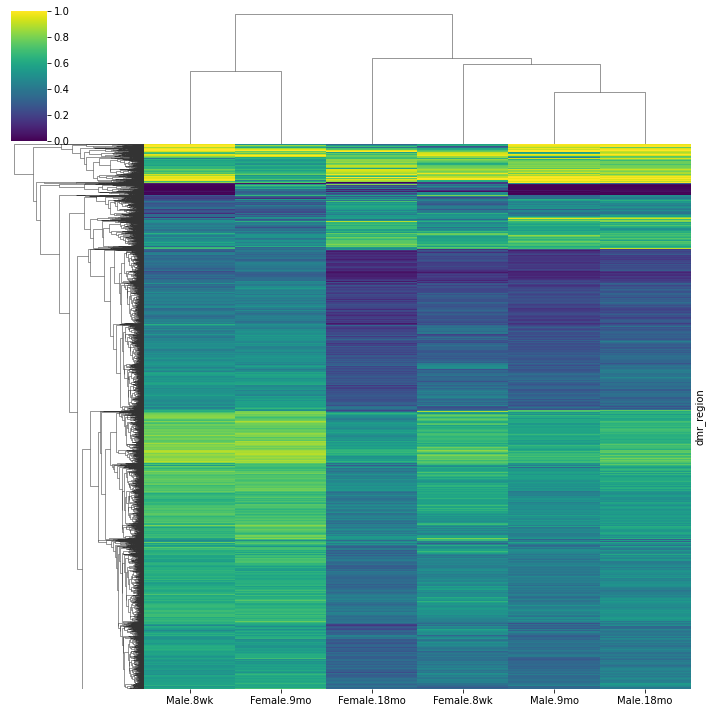

In [67]:
#fig, ax = plt.subplots(figsize= (4,3), dpi = 200)
clustergrid = sns.clustermap(
            data = to_plot,
            # vmin = -2,
            # vmax = 2,
            cmap = 'viridis',
            yticklabels=False,
           )

Text(0.5, 1.0, 'mCG level of STR_D1_Gaba aDMRs')

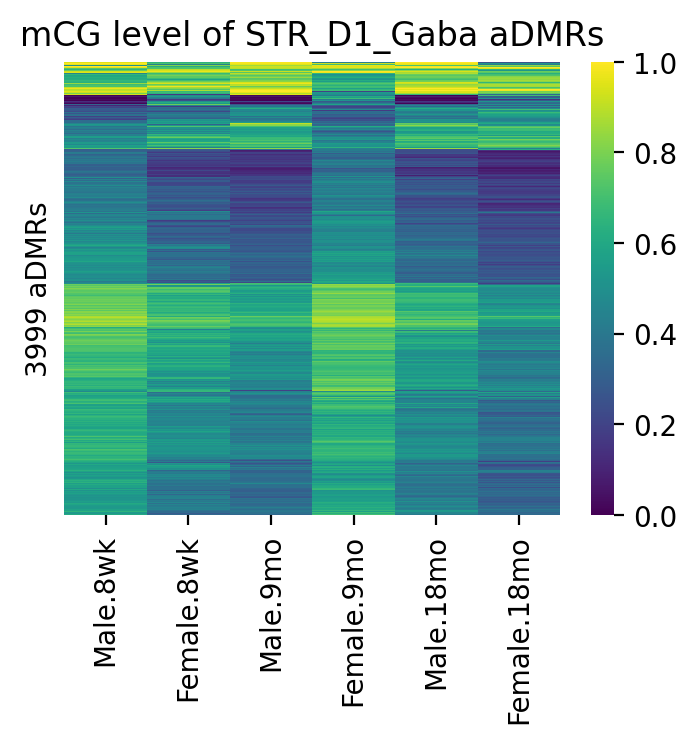

In [68]:
to_plot.index = range(0,to_plot.shape[0])
reordered_to_plot = to_plot.loc[clustergrid.dendrogram_row.reordered_ind]

fig, ax = plt.subplots(figsize= (4,3), dpi = 200)
sns.heatmap(
            data = reordered_to_plot,
            vmin = 0,
            vmax = 1,
            cmap = 'viridis',
            yticklabels=False,
            rasterized = True
           )
ax.set(ylabel = f'{reordered_to_plot.shape[0]} aDMRs')
ax.set_title(f"mCG level of {celltype} aDMRs")
#fig.savefig(f"figure/{celltype}.heatmap.aDMR-mCG.pdf",  bbox_inches = 'tight')

In [22]:
# male_frac_df['male_mCG_change'] = male_frac_df['Oligo_NN.18mo'] - male_frac_df['Oligo_NN.8wk']
# female_frac_df['female_mCG_change'] = female_frac_df[f'Oligo-NN.18mo'] - female_frac_df[f'Oligo-NN.8wk']

In [23]:
# to_plot = pd.concat([male_frac_df['male_mCG_change'],female_frac_df['female_mCG_change']], axis = 1)

In [24]:
# to_plot.to_csv('Jey/scatterplot.csv')

In [25]:
# fig, ax = plt.subplots(figsize = (4,4), dpi = 200)
# sns.scatterplot(data = to_plot, 
#                 ax = ax,
#                 x = 'male_mCG_change',
#                 y= 'female_mCG_change',
#                 s = 2)
# ax.set(xlim = (-0.6,0.6), ylim = (-0.6,0.6))
# ax.set_title(f"{celltype} gender-shared aDMR")
# ax.plot([-0.6, 0.6], [-0.6, 0.6], color='red', linestyle='--', lw = '1')
# fig.savefig(f"figure/{celltype}.scatter.gender_corr.pdf",  bbox_inches = 'tight')

## calculate corr

In [69]:
from ALLCools.mcds.correlation import corr_rows
from scipy.stats import norm

In [70]:
obs_dim='sample'
region_dim='dmr_region'

In [71]:
def get_frac_df(path):
    mcds = MCDS.open(
        mcds_paths = path, 
        obs_dim=obs_dim, 
        var_dim=region_dim)

    mc_df = mcds['dmr_region_da'].sel(count_type = 'mc')
    cov_df = mcds['dmr_region_da'].sel(count_type = 'cov')
    frac_df = mc_df/cov_df
    frac_df = frac_df.to_pandas()
    return frac_df

In [72]:
def shuffle_age(male_frac_df, female_frac_df):
    shuffle_male_frac_df = male_frac_df.copy()
    for row, data in shuffle_male_frac_df.iterrows():
        n_gene = shuffle_male_frac_df.shape[1]
        shuffle_male_frac_df.loc[row] = shuffle_male_frac_df.loc[row].sample(n_gene).values

    shuffle_female_frac_df = female_frac_df.copy()
    for row, data in shuffle_female_frac_df.iterrows():
        n_gene = shuffle_female_frac_df.shape[1]
        shuffle_female_frac_df.loc[row] = shuffle_female_frac_df.loc[row].sample(n_gene).values

    shuffle_corr = corr_rows(shuffle_male_frac_df, shuffle_female_frac_df)
    shuffle_corr = pd.Series(shuffle_corr, index=male_frac_df.index)
    
    return shuffle_corr

In [77]:
import joblib
use_mc_cts = joblib.load('/home/qzeng/project/aging/metadata/mc_use_cts')
use_m3c_cts = joblib.load('/home/qzeng/project/aging/metadata/m3c_use_cts')

use_cts = list(set(use_mc_cts) & set(use_m3c_cts))
use_cts = [ct.replace(' ','_').replace('/','') for ct in use_cts]

all_celltypes = use_cts

In [75]:
# all_celltypes = [path.split('/')[-1].split('.')[0] for path in glob.glob('mC_FILTER_DMR_BED/*.Total.aDMR.bed') if ]

In [78]:
all_corr_df_list = []
for celltype in tqdm(all_celltypes):
    # get mc frac ds
    male_path = f"Male_DMR_ZARR/{celltype}"
    female_path = f"Female_DMR_ZARR/{celltype}"
    male_frac_df = get_frac_df(male_path).T
    female_frac_df = get_frac_df(female_path).T
    
    #order df
    desired_order = ['8wk', '9mo', '18mo']
    male_frac_df = male_frac_df[sorted(male_frac_df.columns, key=lambda x: desired_order.index(x.split('.')[-1]))]
    female_frac_df = female_frac_df[sorted(female_frac_df.columns, key=lambda x: desired_order.index(x.split('.')[-1]))]
    
    #shuffle data
    shuffle_corr = shuffle_age(male_frac_df, female_frac_df)
    
    # corr rows
    dmr_corr = corr_rows(male_frac_df, female_frac_df).ravel()
    dmr_corr = pd.Series(dmr_corr, index=male_frac_df.index)
    
    corr_df = pd.DataFrame(pd.concat([dmr_corr,shuffle_corr], axis = 1))
    corr_df.columns = ['aDMR Corr.','Shuffle Corr.']
    
    # give catagory
    hypo_dmrs = pd.read_csv(f'mC_FILTER_DMR_BED/{celltype}.Hypo.aDMR.bed', sep = '\t', header = None)[3].tolist()
    hyper_dmrs = pd.read_csv(f'mC_FILTER_DMR_BED/{celltype}.Hyper.aDMR.bed', sep = '\t', header = None)[3].tolist()
    
    # get corr_df
    corr_df['dmr_catagory'] = corr_df.index.map(lambda x: 'hypo' if x in hypo_dmrs else ('hyper' if x in hyper_dmrs else 'changing'))
    corr_df  = corr_df.dropna()
    
    all_corr_df_list.append(corr_df)

100%|████████████████████████████████████████████████████████████████████████████| 36/36 [07:29<00:00, 12.48s/it]


In [79]:
all_corr_df = pd.concat(all_corr_df_list, axis = 0)

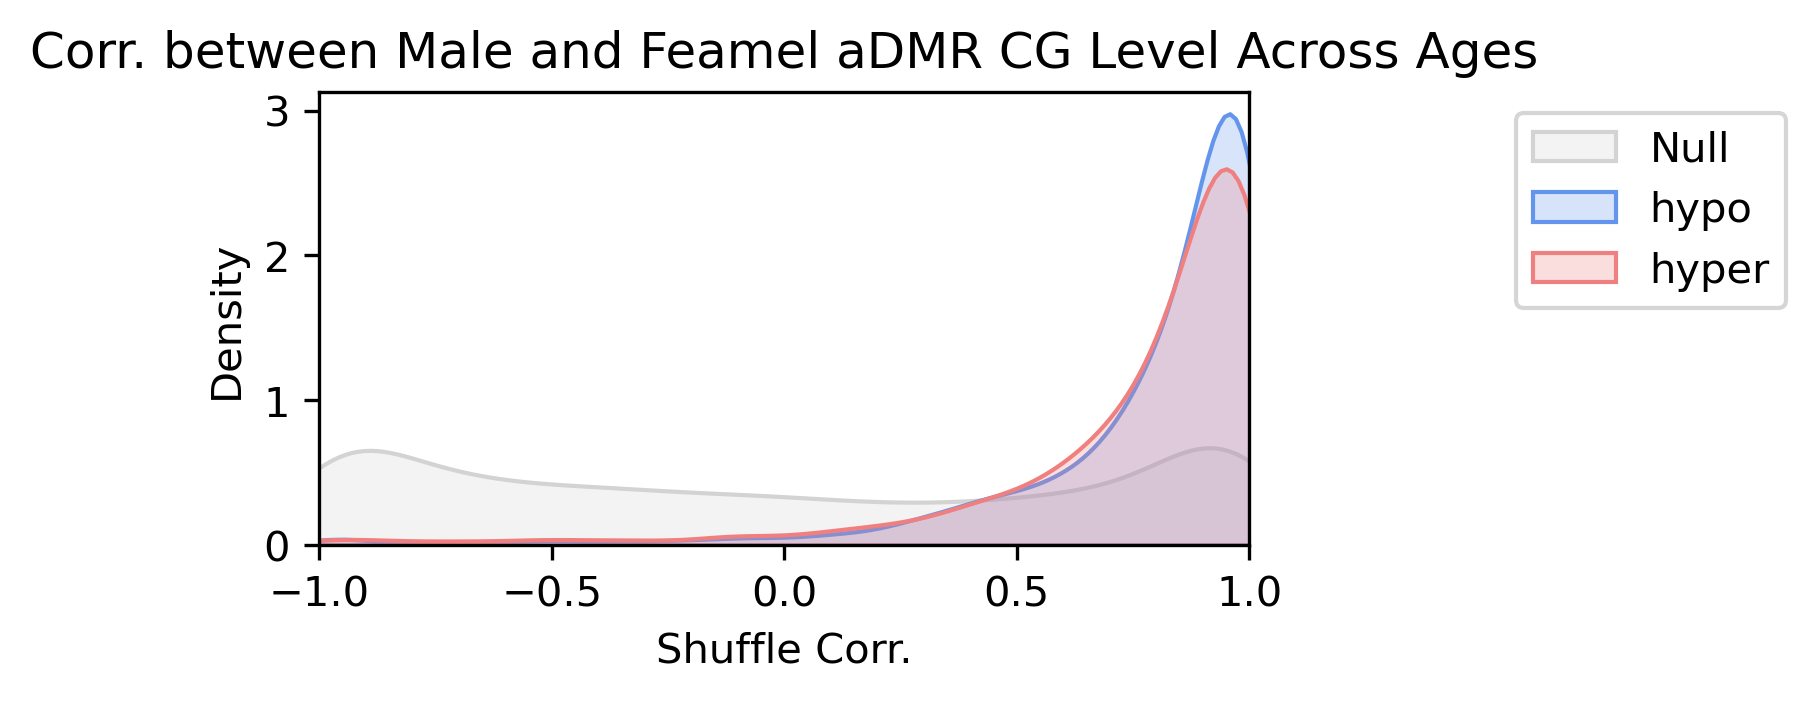

In [81]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)

sns.kdeplot(
    data=corr_df['Shuffle Corr.'], bw_adjust=1, ax=ax, fill=True, color="lightgrey", label="Null"
)

sns.kdeplot(
    corr_df.loc[corr_df.dmr_catagory == 'hypo']["aDMR Corr."],
    bw_adjust=1,
    ax=ax,
    fill=True,
    color='cornflowerblue',
    label="hypo",
)

sns.kdeplot(
    corr_df.loc[corr_df.dmr_catagory == 'hyper']["aDMR Corr."],
    bw_adjust=1,
    ax=ax,
    fill=True,
    color='lightcoral',
    label="hyper",
)

# sns.kdeplot(
#     corr_df.loc[corr_df.dmr_catagory == 'changing']["aDMR Corr."],
#     bw_adjust=1,
#     ax=ax,
#     fill=True,
#     color='green',
#     label="changing",
# )

ax.set(xlim = (-1, 1))
ax.legend(bbox_to_anchor=(1.6, 1))
ax.set_title('Corr. between Male and Feamel aDMR CG Level Across Ages')
fig.savefig("figure/Female-Male.corr.no-changing.pdf", bbox_inches = 'tight')

In [115]:
!pwd

/home/qzeng/project/aging/230907-recall-dmr/Merge_DMR
